### This Code is about classifying different type of pokemon using VGG16 Transfer Learning.
                                            by Mansion See Lui
#### To be exact, there are 5 types of pokemon to be classify.
#### The data provided have 50 picture for each type of pokemon.

Note: If it cause an error during fit stage, may need to install a lower version of tensorflow. Tensorflow version = 2.2.0. 

!pip unistall -y tensorflow (to uninstall)

!pip install tensorflow==2.2.0 (to install)

And of course all other library use you may need to pip install.

#### What is the process of this training and validation file?
A. Pre coding
   1. Create training and validation directory.
   2. On training and validation directory, each pokemon type have each folder.
   3. The training and validation data are split into 80% and 20% respectively at random.
   4. Copy the original files into the training and validation directory.
   
B. Pre processing of data
   1. Image Data Generator with rescaling. (validation is rescale only)
   2. Resize the training and validation data
   
C. Transfer Learning Preparation
   1. Load VGG16 model and Fix the weight of all layer.
   2. Prepare the model with customize output layer.
   3. Fit and select an optimizer base on accuracy.
   4. Add layer on the output layer with different number of nodes.
   5. Fit and select appropriate output layer base on accuracy.
   6. Load VGG16 model with weight of the last block set to trainable.
   7. Fit and run with different output layer setting.
   8. Load VGG16 model, set all layer to be trainable.
   9. Fit and run with selected output layer.

D. Summary of Results

E. Make conclusion and select model

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
np.random.seed(42)

# Set the raw data and processed data directory
raw_data_dir = './pokemon'

#### Note:
#### Below two line of code remove the train and val directory derive from pokemon files.
#### If the train and val directory doesn't exist, there will be error in the code. Not an issue, just proceed to run the rest.
#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
def remove(path):
    """ param <path> could either be relative or absolute. """
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)  # remove the file
    elif os.path.isdir(path):
        shutil.rmtree(path)  # remove dir and all contains
    else:
        raise ValueError("file {} is not a file or dir.".format(path))

In [4]:
train_dir = raw_data_dir+'/train'
val_dir = raw_data_dir+'/val'

remove(train_dir)
remove(val_dir)


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Pre processing of the data. Segregating into train and validation data.
### The split is 80% training data and 20% validation data.

In [5]:
# Collecting files of type *.jpg and *.png. Can add different type of picture extension.
# Reason for doing this because of the thumbs.db keep appearing.
files_1 = glob.glob(raw_data_dir+'/*/*.jpg')
files_2 = glob.glob(raw_data_dir+'/*/*.png')
files = files_1 + files_2

# check all quantity of the data file of each category
pokemon_file = {}
data_dir = os.listdir(raw_data_dir)
for d in data_dir:
    key = d+'_files'
    pokemon_file[key] = [fn for fn in files if d in fn]
    print(d, ' ', len(pokemon_file[key]))

squirtle   50
mewtwo   50
bulbasaur   50
charmander   50
pikachu   50


In [6]:
# setting up the training and validation size
train_size = 40
val_size = 10

# getting the file path for training data and validation data
pokemon_train = {}
pokemon_val = {}

for key in pokemon_file:
    key_1 = key[:-6]+'_train'
    key_2 = key[:-6]+'_val'
    pokemon_train[key_1] = np.random.choice(pokemon_file[key], size=train_size, replace=False)
    temp = list(set(pokemon_file[key]) - set(pokemon_train[key_1]))
    pokemon_val[key_2] = np.random.choice(temp, size=val_size, replace=False)
    print(key[:-6],' datasets:', pokemon_train[key_1].shape, pokemon_val[key_2].shape)   

squirtle  datasets: (40,) (10,)
mewtwo  datasets: (40,) (10,)
bulbasaur  datasets: (40,) (10,)
charmander  datasets: (40,) (10,)
pikachu  datasets: (40,) (10,)


In [7]:
# setting up and creating the train and validation directory
train_dir = '/train'
val_dir = '/val'

os.mkdir(raw_data_dir+train_dir) if not os.path.isdir(raw_data_dir+train_dir) else None
os.mkdir(raw_data_dir+val_dir) if not os.path.isdir(raw_data_dir+val_dir) else None

In [8]:
# copy from the original folder of pokemon images into train and val folder
for train_file in pokemon_train.keys():
    d = train_file[:-6]
    os.mkdir(raw_data_dir+train_dir+'/'+d) if not os.path.isdir(raw_data_dir+train_dir+'/'+d) else None
    for fn in pokemon_train[train_file]:
        shutil.copy(fn, raw_data_dir+train_dir+'/'+d)
for val_file in pokemon_val.keys():
    d = val_file[:-4]
    os.mkdir(raw_data_dir+val_dir+'/'+d) if not os.path.isdir(raw_data_dir+val_dir+'/'+d) else None
    for fn in pokemon_val[val_file]:
        shutil.copy(fn, raw_data_dir+val_dir+'/'+d)

#### Additional data preprocessing for training, using the ImageDataGenerator

In [9]:
# Setting up the image data generator for the training data and validation data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    rescale=1./255,
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)


datagen_valid = ImageDataGenerator(rescale=1./255, samplewise_center=True)

In [10]:
# Image dimension setting for input to Neural Network
img_x = 224
img_y = 224

In [12]:
# load and iterate training dataset and reshaping the picture size
train_it = datagen_train.flow_from_directory(
    "./pokemon/train",
    target_size=(img_x,img_y),
    batch_size= 25,
    color_mode="rgb",
    class_mode="categorical"
)
# load and iterate validation dataset and reshaping the picture size
valid_it = datagen_valid.flow_from_directory(
    "./pokemon/val",
    target_size=(img_x,img_y),
    batch_size= 25,
    color_mode="rgb",
    class_mode="categorical"
)

Found 200 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


### Preparation of Transfer Learning using VGG16.

In [13]:
# Loading VGG16 model for transfer learning

from tensorflow import keras

base_model_vgg16 = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(img_x,img_y, 3),
    include_top=False)

2022-04-19 03:27:13.419097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-19 03:27:13.517002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: NVIDIA A100-SXM4-40GB MIG 2g.10gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 28 deviceMemorySize: 9.75GiB deviceMemoryBandwidth: 362.10GiB/s
2022-04-19 03:27:13.517317: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-19 03:27:13.517413: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file: No su

In [14]:
# Setting up the transfer learning
base_model_vgg16.trainable = False

In [15]:
# Setup 1 VGG16 with base model of vgg16 = false, top layer of Global Average Pooling 2D and then Dense 5 activation softmax 
# for output. Compiler optimizer is RMSprop

# Create inputs with correct shape
inputs = keras.Input(shape=(img_x,img_y, 3))

x = base_model_vgg16(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model_vgg16 = keras.Model(inputs, outputs)

model_vgg16.compile(optimizer=keras.optimizers.RMSprop(),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [16]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


#### Using RMSprop optimizer

In [17]:
# Training for setup 1.

history = model_vgg16.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 13s 2s/step - loss: 1.6035 - categorical_accuracy: 0.2750 - val_loss: 1.5973 - val_categorical_accuracy: 0.2600
Epoch 2/100
8/8 [==============================] - 13s 2s/step - loss: 1.5883 - categorical_accuracy: 0.3200 - val_loss: 1.5864 - val_categorical_accuracy: 0.3000
Epoch 3/100
8/8 [==============================] - 13s 2s/step - loss: 1.5783 - categorical_accuracy: 0.3650 - val_loss: 1.5765 - val_categorical_accuracy: 0.3400
Epoch 4/100
8/8 [==============================] - 13s 2s/step - loss: 1.5671 - categorical_accuracy: 0.4500 - val_loss: 1.5677 - val_categorical_accuracy: 0.4200
Epoch 5/100
8/8 [==============================] - 13s 2s/step - loss: 1.5575 - categorical_accuracy: 0.4600 - val_loss: 1.5590 - val_categorical_accuracy: 0.4200
Epoch 6/100
8/8 [==============================] - 13s 2s/step - loss: 1.5467 - categorical_accuracy: 0.4800 - val_loss: 1.5500 - val_categorical_accuracy: 0.4800
Epoch 7/100
8/8 [=====

8/8 [==============================] - 12s 2s/step - loss: 1.2804 - categorical_accuracy: 0.7650 - val_loss: 1.3472 - val_categorical_accuracy: 0.6400
Epoch 52/100
8/8 [==============================] - 12s 1s/step - loss: 1.2754 - categorical_accuracy: 0.7750 - val_loss: 1.3440 - val_categorical_accuracy: 0.6600
Epoch 53/100
8/8 [==============================] - 12s 2s/step - loss: 1.2700 - categorical_accuracy: 0.7600 - val_loss: 1.3421 - val_categorical_accuracy: 0.6600
Epoch 54/100
8/8 [==============================] - 12s 1s/step - loss: 1.2681 - categorical_accuracy: 0.7450 - val_loss: 1.3399 - val_categorical_accuracy: 0.6600
Epoch 55/100
8/8 [==============================] - 11s 1s/step - loss: 1.2593 - categorical_accuracy: 0.7800 - val_loss: 1.3369 - val_categorical_accuracy: 0.6800
Epoch 56/100
8/8 [==============================] - 12s 2s/step - loss: 1.2621 - categorical_accuracy: 0.7900 - val_loss: 1.3347 - val_categorical_accuracy: 0.6600
Epoch 57/100
8/8 [===========

In [18]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  83.5 %
val accuracy:  75.2 %


In [19]:
# Function definition for plotting loss and accuracy. This will be use for all iteration.

def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color='red', label='Val loss')
    plt.plot(x, train_loss, label='Train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()

def plot_accuracy(history):
    train_acc = history.history['categorical_accuracy']
    test_acc = history.history['val_categorical_accuracy']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color='red', label='Val accuracy')
    plt.plot(x, train_acc, label='Train accuracy')  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, 100])
    #plt.ylim([0, 100])
    plt.title('Accuracy vs. Epoch')  
    plt.legend(loc='lower right')

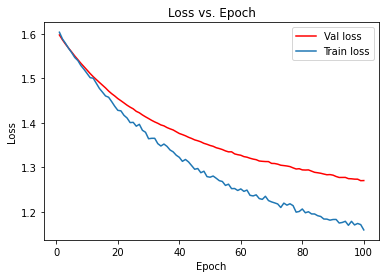

In [20]:
plot_loss(history)

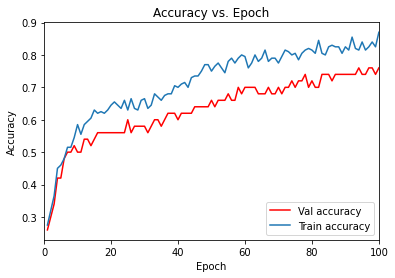

In [21]:
plot_accuracy(history)

#### Same setup, but using SGD optimizer

In [22]:
# Same setup as Setup 1 but different compiler. Compiler optimizer is SGD

model_vgg16.compile(optimizer=keras.optimizers.SGD(),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [23]:
history = model_vgg16.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 1.1591 - categorical_accuracy: 0.8350 - val_loss: 1.2698 - val_categorical_accuracy: 0.7600
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.1633 - categorical_accuracy: 0.8450 - val_loss: 1.2700 - val_categorical_accuracy: 0.7600
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 1.1635 - categorical_accuracy: 0.8450 - val_loss: 1.2699 - val_categorical_accuracy: 0.7400
Epoch 4/100
8/8 [==============================] - 11s 1s/step - loss: 1.1624 - categorical_accuracy: 0.8450 - val_loss: 1.2694 - val_categorical_accuracy: 0.7400
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 1.1590 - categorical_accuracy: 0.8400 - val_loss: 1.2698 - val_categorical_accuracy: 0.7600
Epoch 6/100
8/8 [==============================] - 12s 1s/step - loss: 1.1618 - categorical_accuracy: 0.8400 - val_loss: 1.2699 - val_categorical_accuracy: 0.7600
Epoch 7/100
8/8 [=====

8/8 [==============================] - 12s 1s/step - loss: 1.1597 - categorical_accuracy: 0.8250 - val_loss: 1.2679 - val_categorical_accuracy: 0.7600
Epoch 52/100
8/8 [==============================] - 12s 1s/step - loss: 1.1562 - categorical_accuracy: 0.8600 - val_loss: 1.2677 - val_categorical_accuracy: 0.7400
Epoch 53/100
8/8 [==============================] - 11s 1s/step - loss: 1.1596 - categorical_accuracy: 0.8450 - val_loss: 1.2676 - val_categorical_accuracy: 0.7400
Epoch 54/100
8/8 [==============================] - 12s 2s/step - loss: 1.1649 - categorical_accuracy: 0.8250 - val_loss: 1.2676 - val_categorical_accuracy: 0.7400
Epoch 55/100
8/8 [==============================] - 12s 2s/step - loss: 1.1670 - categorical_accuracy: 0.8300 - val_loss: 1.2674 - val_categorical_accuracy: 0.7400
Epoch 56/100
8/8 [==============================] - 12s 1s/step - loss: 1.1573 - categorical_accuracy: 0.8650 - val_loss: 1.2679 - val_categorical_accuracy: 0.7400
Epoch 57/100
8/8 [===========

In [24]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  86.1 %
val accuracy:  75.2 %


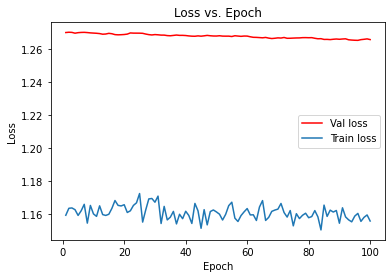

In [25]:
plot_loss(history)

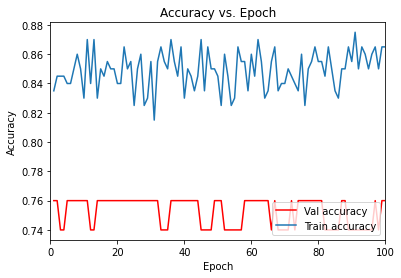

In [26]:
plot_accuracy(history)

#### Same Setup, but use Adam optimizer

In [27]:
# Same setup as Setup 1 but different compiler. Compiler optimizer is ADAM

model_vgg16.compile(optimizer=keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [28]:
history = model_vgg16.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 13s 2s/step - loss: 1.1477 - categorical_accuracy: 0.8550 - val_loss: 1.2633 - val_categorical_accuracy: 0.7600
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.1531 - categorical_accuracy: 0.8550 - val_loss: 1.2625 - val_categorical_accuracy: 0.7600
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 1.1526 - categorical_accuracy: 0.8600 - val_loss: 1.2607 - val_categorical_accuracy: 0.7600
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 1.1575 - categorical_accuracy: 0.8350 - val_loss: 1.2602 - val_categorical_accuracy: 0.7600
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 1.1610 - categorical_accuracy: 0.8400 - val_loss: 1.2590 - val_categorical_accuracy: 0.7600
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 1.1493 - categorical_accuracy: 0.8450 - val_loss: 1.2577 - val_categorical_accuracy: 0.7600
Epoch 7/100
8/8 [=====

8/8 [==============================] - 11s 1s/step - loss: 1.0962 - categorical_accuracy: 0.9000 - val_loss: 1.2196 - val_categorical_accuracy: 0.8000
Epoch 52/100
8/8 [==============================] - 12s 1s/step - loss: 1.1001 - categorical_accuracy: 0.8800 - val_loss: 1.2183 - val_categorical_accuracy: 0.8000
Epoch 53/100
8/8 [==============================] - 11s 1s/step - loss: 1.1004 - categorical_accuracy: 0.8850 - val_loss: 1.2193 - val_categorical_accuracy: 0.8000
Epoch 54/100
8/8 [==============================] - 12s 1s/step - loss: 1.1041 - categorical_accuracy: 0.8650 - val_loss: 1.2184 - val_categorical_accuracy: 0.8000
Epoch 55/100
8/8 [==============================] - 11s 1s/step - loss: 1.0930 - categorical_accuracy: 0.8850 - val_loss: 1.2171 - val_categorical_accuracy: 0.8000
Epoch 56/100
8/8 [==============================] - 11s 1s/step - loss: 1.0857 - categorical_accuracy: 0.8900 - val_loss: 1.2176 - val_categorical_accuracy: 0.8000
Epoch 57/100
8/8 [===========

In [29]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  91.9 %
val accuracy:  84.8 %


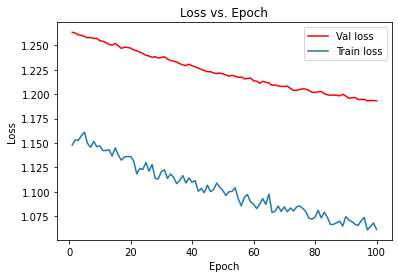

In [30]:
plot_loss(history)

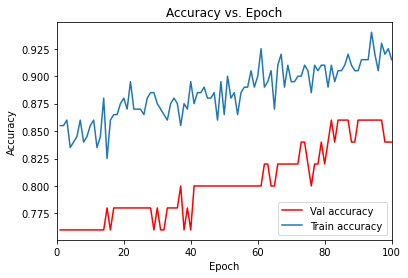

In [31]:
plot_accuracy(history)

### Setup 1 with 3 different optimizer (RMSprop, SGD and Adam)
#### Results as shown below:
                              Training Accuracy      Validation Accuracy
                    RMSprop        83.5%                   75.2%
                    SGD            86.1%                   75.2%
                    ADAM           91.9%                   84.8%
*The accuracy is estimated average of the last 5 epoch
                             

### So on Setup 1 experiment, we can say that adam optimizer give us a good results.
### Next Step, is we try to add one more dense layer before the output dense layer.

#### Add Dense Layer 512 nodes and activation relu.

In [32]:
# Create inputs with correct shape
inputs = keras.Input(shape=(img_x,img_y, 3))

x = base_model_vgg16(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation = 'relu')(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model_vgg16_512 = keras.Model(inputs, outputs)

model_vgg16_512.compile(optimizer=keras.optimizers.Adam(),
                        loss = keras.losses.CategoricalCrossentropy(from_logits=True) , 
                        metrics = [keras.metrics.CategoricalAccuracy()])

In [33]:
model_vgg16_512.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
history = model_vgg16_512.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 1.5986 - categorical_accuracy: 0.2650 - val_loss: 1.5412 - val_categorical_accuracy: 0.3600
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.5093 - categorical_accuracy: 0.4700 - val_loss: 1.4874 - val_categorical_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 1.4434 - categorical_accuracy: 0.5950 - val_loss: 1.4361 - val_categorical_accuracy: 0.5600
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 1.3818 - categorical_accuracy: 0.6150 - val_loss: 1.3960 - val_categorical_accuracy: 0.5600
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 1.3422 - categorical_accuracy: 0.6500 - val_loss: 1.3738 - val_categorical_accuracy: 0.5600
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 1.3113 - categorical_accuracy: 0.6550 - val_loss: 1.3482 - val_categorical_accuracy: 0.6000
Epoch 7/100
8/8 [=====

8/8 [==============================] - 12s 1s/step - loss: 0.9636 - categorical_accuracy: 0.9700 - val_loss: 1.1268 - val_categorical_accuracy: 0.7800
Epoch 52/100
8/8 [==============================] - 11s 1s/step - loss: 0.9683 - categorical_accuracy: 0.9550 - val_loss: 1.1223 - val_categorical_accuracy: 0.8200
Epoch 53/100
8/8 [==============================] - 11s 1s/step - loss: 0.9537 - categorical_accuracy: 0.9750 - val_loss: 1.1119 - val_categorical_accuracy: 0.8200
Epoch 54/100
8/8 [==============================] - 13s 2s/step - loss: 0.9518 - categorical_accuracy: 0.9800 - val_loss: 1.1208 - val_categorical_accuracy: 0.8000
Epoch 55/100
8/8 [==============================] - 12s 1s/step - loss: 0.9453 - categorical_accuracy: 0.9900 - val_loss: 1.0942 - val_categorical_accuracy: 0.8400
Epoch 56/100
8/8 [==============================] - 11s 1s/step - loss: 0.9512 - categorical_accuracy: 0.9800 - val_loss: 1.1150 - val_categorical_accuracy: 0.8400
Epoch 57/100
8/8 [===========

In [35]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  99.3 %
val accuracy:  84.0 %


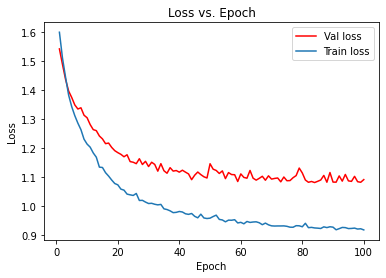

In [36]:
plot_loss(history)

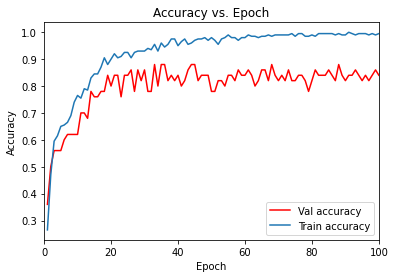

In [37]:
plot_accuracy(history)

#### Add Dense Layer 256 nodes and activation relu.

In [38]:
# Create inputs with correct shape
inputs = keras.Input(shape=(img_x,img_y, 3))

x = base_model_vgg16(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation = 'relu')(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model_vgg16_256 = keras.Model(inputs, outputs)

model_vgg16_256.compile(optimizer=keras.optimizers.Adam(),
                        loss = keras.losses.CategoricalCrossentropy(from_logits=True) , 
                        metrics = [keras.metrics.CategoricalAccuracy()])

In [39]:
model_vgg16_256.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
history = model_vgg16_256.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 1.6012 - categorical_accuracy: 0.2500 - val_loss: 1.5620 - val_categorical_accuracy: 0.3800
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.5422 - categorical_accuracy: 0.4550 - val_loss: 1.5101 - val_categorical_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 1.4881 - categorical_accuracy: 0.5100 - val_loss: 1.4637 - val_categorical_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 1.4263 - categorical_accuracy: 0.6050 - val_loss: 1.4356 - val_categorical_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 12s 2s/step - loss: 1.3965 - categorical_accuracy: 0.6000 - val_loss: 1.3994 - val_categorical_accuracy: 0.5400
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 1.3677 - categorical_accuracy: 0.5900 - val_loss: 1.3811 - val_categorical_accuracy: 0.5400
Epoch 7/100
8/8 [=====

8/8 [==============================] - 12s 1s/step - loss: 0.9888 - categorical_accuracy: 0.9500 - val_loss: 1.1270 - val_categorical_accuracy: 0.8000
Epoch 52/100
8/8 [==============================] - 12s 1s/step - loss: 0.9813 - categorical_accuracy: 0.9600 - val_loss: 1.1115 - val_categorical_accuracy: 0.8400
Epoch 53/100
8/8 [==============================] - 11s 1s/step - loss: 0.9787 - categorical_accuracy: 0.9600 - val_loss: 1.1141 - val_categorical_accuracy: 0.8400
Epoch 54/100
8/8 [==============================] - 11s 1s/step - loss: 0.9733 - categorical_accuracy: 0.9600 - val_loss: 1.1208 - val_categorical_accuracy: 0.8200
Epoch 55/100
8/8 [==============================] - 12s 1s/step - loss: 0.9850 - categorical_accuracy: 0.9650 - val_loss: 1.1023 - val_categorical_accuracy: 0.8800
Epoch 56/100
8/8 [==============================] - 11s 1s/step - loss: 0.9694 - categorical_accuracy: 0.9700 - val_loss: 1.1216 - val_categorical_accuracy: 0.7800
Epoch 57/100
8/8 [===========

In [41]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  99.1 %
val accuracy:  85.2 %


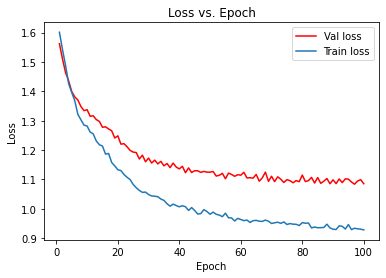

In [42]:
plot_loss(history)

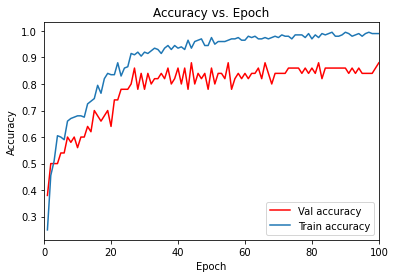

In [43]:
plot_accuracy(history)

#### Add Dense Layer 128 nodes and activation relu.

In [44]:
# Create inputs with correct shape
inputs = keras.Input(shape=(img_x,img_y, 3))

x = base_model_vgg16(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model_vgg16_128 = keras.Model(inputs, outputs)

model_vgg16_128.compile(optimizer=keras.optimizers.Adam(),
                        loss = keras.losses.CategoricalCrossentropy(from_logits=True) , 
                        metrics = [keras.metrics.CategoricalAccuracy()])

In [45]:
model_vgg16_128.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 66,309
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
history = model_vgg16_128.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 12s 2s/step - loss: 1.6204 - categorical_accuracy: 0.2300 - val_loss: 1.5945 - val_categorical_accuracy: 0.2600
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.5844 - categorical_accuracy: 0.3000 - val_loss: 1.5634 - val_categorical_accuracy: 0.4000
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 1.5437 - categorical_accuracy: 0.4800 - val_loss: 1.5280 - val_categorical_accuracy: 0.5600
Epoch 4/100
8/8 [==============================] - 11s 1s/step - loss: 1.5035 - categorical_accuracy: 0.5950 - val_loss: 1.4941 - val_categorical_accuracy: 0.5400
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 1.4621 - categorical_accuracy: 0.6150 - val_loss: 1.4585 - val_categorical_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 1.4193 - categorical_accuracy: 0.6400 - val_loss: 1.4267 - val_categorical_accuracy: 0.5800
Epoch 7/100
8/8 [=====

8/8 [==============================] - 11s 1s/step - loss: 0.9995 - categorical_accuracy: 0.9550 - val_loss: 1.1496 - val_categorical_accuracy: 0.8200
Epoch 52/100
8/8 [==============================] - 11s 1s/step - loss: 0.9966 - categorical_accuracy: 0.9500 - val_loss: 1.1518 - val_categorical_accuracy: 0.8000
Epoch 53/100
8/8 [==============================] - 11s 1s/step - loss: 0.9932 - categorical_accuracy: 0.9500 - val_loss: 1.1373 - val_categorical_accuracy: 0.8200
Epoch 54/100
8/8 [==============================] - 10s 1s/step - loss: 1.0033 - categorical_accuracy: 0.9300 - val_loss: 1.1361 - val_categorical_accuracy: 0.8200
Epoch 55/100
8/8 [==============================] - 11s 1s/step - loss: 0.9999 - categorical_accuracy: 0.9500 - val_loss: 1.1542 - val_categorical_accuracy: 0.7600
Epoch 56/100
8/8 [==============================] - 10s 1s/step - loss: 0.9939 - categorical_accuracy: 0.9500 - val_loss: 1.1323 - val_categorical_accuracy: 0.8600
Epoch 57/100
8/8 [===========

In [47]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  98.7 %
val accuracy:  84.0 %


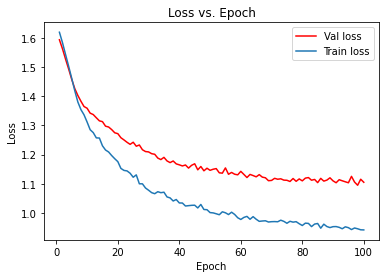

In [48]:
plot_loss(history)

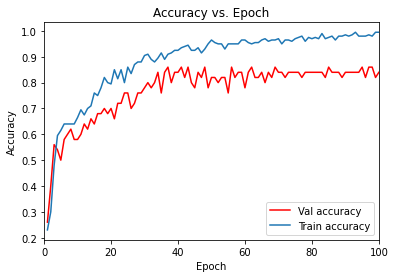

In [49]:
plot_accuracy(history)

#### Add Dense Layer 64 nodes and activation relu.

In [50]:
# Create inputs with correct shape
inputs = keras.Input(shape=(img_x,img_y, 3))

x = base_model_vgg16(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)

# Add final dense layer
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model_vgg16_64 = keras.Model(inputs, outputs)

model_vgg16_64.compile(optimizer=keras.optimizers.Adam(),
                       loss = keras.losses.CategoricalCrossentropy(from_logits=True) , 
                       metrics = [keras.metrics.CategoricalAccuracy()])

In [51]:
model_vgg16_64.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 14,747,845
Trainable params: 33,157
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
history = model_vgg16_64.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(round(train_it.samples/train_it.batch_size)),
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=100)

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 1.6115 - categorical_accuracy: 0.1950 - val_loss: 1.5894 - val_categorical_accuracy: 0.3600
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.5810 - categorical_accuracy: 0.4000 - val_loss: 1.5620 - val_categorical_accuracy: 0.4400
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 1.5530 - categorical_accuracy: 0.4250 - val_loss: 1.5328 - val_categorical_accuracy: 0.4400
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 1.5182 - categorical_accuracy: 0.4850 - val_loss: 1.5007 - val_categorical_accuracy: 0.4600
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 1.4891 - categorical_accuracy: 0.5700 - val_loss: 1.4727 - val_categorical_accuracy: 0.5200
Epoch 6/100
8/8 [==============================] - 10s 1s/step - loss: 1.4495 - categorical_accuracy: 0.6000 - val_loss: 1.4462 - val_categorical_accuracy: 0.5200
Epoch 7/100
8/8 [=====

8/8 [==============================] - 10s 1s/step - loss: 1.0303 - categorical_accuracy: 0.9350 - val_loss: 1.1611 - val_categorical_accuracy: 0.8000
Epoch 52/100
8/8 [==============================] - 10s 1s/step - loss: 1.0233 - categorical_accuracy: 0.9200 - val_loss: 1.1474 - val_categorical_accuracy: 0.8400
Epoch 53/100
8/8 [==============================] - 10s 1s/step - loss: 1.0265 - categorical_accuracy: 0.9400 - val_loss: 1.1565 - val_categorical_accuracy: 0.8000
Epoch 54/100
8/8 [==============================] - 9s 1s/step - loss: 1.0254 - categorical_accuracy: 0.9350 - val_loss: 1.1483 - val_categorical_accuracy: 0.8200
Epoch 55/100
8/8 [==============================] - 9s 1s/step - loss: 1.0106 - categorical_accuracy: 0.9350 - val_loss: 1.1397 - val_categorical_accuracy: 0.8400
Epoch 56/100
8/8 [==============================] - 10s 1s/step - loss: 1.0030 - categorical_accuracy: 0.9600 - val_loss: 1.1524 - val_categorical_accuracy: 0.8200
Epoch 57/100
8/8 [=============

In [53]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  98.1 %
val accuracy:  80.80000000000001 %


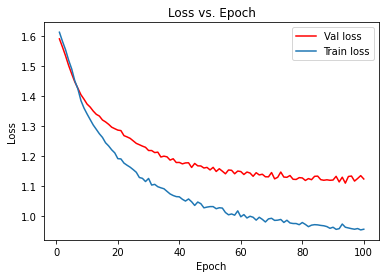

In [54]:
plot_loss(history)

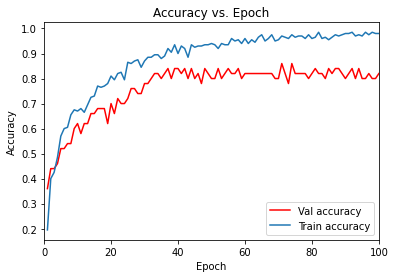

In [55]:
plot_accuracy(history)

### Setup 1 with Adam as optimizer and additional Dense layer that has different number of nodes.
#### Results as shown below:
                no. of nodes  Training Accuracy      Validation Accuracy
                512                 99.3%                   84.0%
                256                 99.1%                   85.2%
                128                 98.7%                   84.0%
                64                  98.1%                   80.8%                           
*The accuracy is estimated average of the last 5 epoch

#### Base on above results, the good candidate for additional layer will Dense 256 and Dense 128.

### Setup 2 Train the top layer and the last block of convolution Network.

In [56]:
base_model_vgg16.trainable = True
base_model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [57]:
for i, layer in enumerate(base_model_vgg16.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_1 (True)
Layer 1: block1_conv1 (True)
Layer 2: block1_conv2 (True)
Layer 3: block1_pool (True)
Layer 4: block2_conv1 (True)
Layer 5: block2_conv2 (True)
Layer 6: block2_pool (True)
Layer 7: block3_conv1 (True)
Layer 8: block3_conv2 (True)
Layer 9: block3_conv3 (True)
Layer 10: block3_pool (True)
Layer 11: block4_conv1 (True)
Layer 12: block4_conv2 (True)
Layer 13: block4_conv3 (True)
Layer 14: block4_pool (True)
Layer 15: block5_conv1 (True)
Layer 16: block5_conv2 (True)
Layer 17: block5_conv3 (True)
Layer 18: block5_pool (True)


In [58]:
for layer in base_model_vgg16.layers[:15]:
  layer.trainable = False

In [59]:
for i, layer in enumerate(base_model_vgg16.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_1 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (True)
Layer 16: block5_conv2 (True)
Layer 17: block5_conv3 (True)
Layer 18: block5_pool (True)


#### without additional dense layer at the output

In [60]:
model_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [61]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


In [62]:
history = model_vgg16.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=30)

Epoch 1/30
8/8 [==============================] - 18s 2s/step - loss: 1.0491 - categorical_accuracy: 0.9350 - val_loss: 1.1518 - val_categorical_accuracy: 0.8200
Epoch 2/30
8/8 [==============================] - 19s 2s/step - loss: 1.0123 - categorical_accuracy: 0.9450 - val_loss: 1.1303 - val_categorical_accuracy: 0.8400
Epoch 3/30
8/8 [==============================] - 19s 2s/step - loss: 1.0044 - categorical_accuracy: 0.9250 - val_loss: 1.1217 - val_categorical_accuracy: 0.8000
Epoch 4/30
8/8 [==============================] - 18s 2s/step - loss: 0.9897 - categorical_accuracy: 0.9350 - val_loss: 1.0882 - val_categorical_accuracy: 0.8600
Epoch 5/30
8/8 [==============================] - 16s 2s/step - loss: 0.9741 - categorical_accuracy: 0.9550 - val_loss: 1.0910 - val_categorical_accuracy: 0.8400
Epoch 6/30
8/8 [==============================] - 18s 2s/step - loss: 0.9751 - categorical_accuracy: 0.9500 - val_loss: 1.0774 - val_categorical_accuracy: 0.9000
Epoch 7/30
8/8 [============

In [63]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  99.5 %
val accuracy:  86.4 %


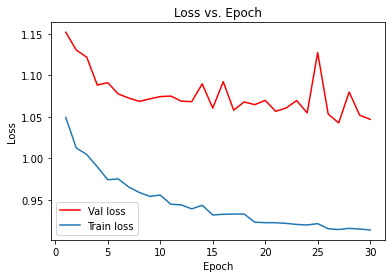

In [64]:
plot_loss(history)

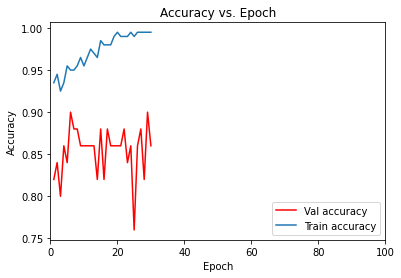

In [65]:
plot_accuracy(history)

#### with additional 128 node at the output dense layer

In [66]:
model_vgg16_128.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [67]:
model_vgg16_128.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 7,145,733
Non-trainable params: 7,635,264
_________________________________________________________________


In [68]:
history = model_vgg16_128.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=30)

Epoch 1/30
8/8 [==============================] - 17s 2s/step - loss: 0.9156 - categorical_accuracy: 0.9900 - val_loss: 1.0641 - val_categorical_accuracy: 0.8600
Epoch 2/30
8/8 [==============================] - 17s 2s/step - loss: 0.9114 - categorical_accuracy: 0.9950 - val_loss: 1.0447 - val_categorical_accuracy: 0.8600
Epoch 3/30
8/8 [==============================] - 16s 2s/step - loss: 0.9111 - categorical_accuracy: 0.9950 - val_loss: 1.0782 - val_categorical_accuracy: 0.8200
Epoch 4/30
8/8 [==============================] - 16s 2s/step - loss: 0.9103 - categorical_accuracy: 0.9950 - val_loss: 1.1192 - val_categorical_accuracy: 0.7800
Epoch 5/30
8/8 [==============================] - 16s 2s/step - loss: 0.9102 - categorical_accuracy: 0.9950 - val_loss: 1.0703 - val_categorical_accuracy: 0.8400
Epoch 6/30
8/8 [==============================] - 15s 2s/step - loss: 0.9100 - categorical_accuracy: 0.9950 - val_loss: 1.0167 - val_categorical_accuracy: 0.9000
Epoch 7/30
8/8 [============

In [69]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  99.5 %
val accuracy:  86.8 %


In [70]:
model_vgg16_128.save('vgg16_last_128_out.h5')

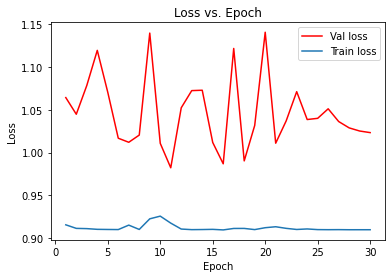

In [71]:
plot_loss(history)

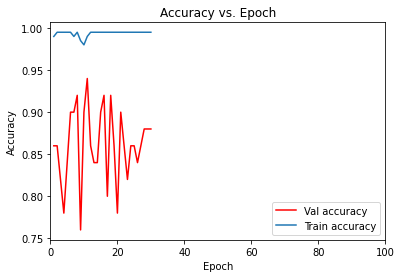

In [72]:
plot_accuracy(history)

#### with additional 256 nodes at the output dense layer

In [73]:
model_vgg16_256.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [74]:
model_vgg16_256.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 7,212,037
Non-trainable params: 7,635,264
_________________________________________________________________


In [75]:
history = model_vgg16_256.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=30)

Epoch 1/30
8/8 [==============================] - 16s 2s/step - loss: 0.9099 - categorical_accuracy: 0.9950 - val_loss: 1.0213 - val_categorical_accuracy: 0.8800
Epoch 2/30
8/8 [==============================] - 17s 2s/step - loss: 0.9126 - categorical_accuracy: 0.9900 - val_loss: 1.0518 - val_categorical_accuracy: 0.8600
Epoch 3/30
8/8 [==============================] - 18s 2s/step - loss: 0.9104 - categorical_accuracy: 0.9950 - val_loss: 1.0675 - val_categorical_accuracy: 0.8200
Epoch 4/30
8/8 [==============================] - 17s 2s/step - loss: 0.9099 - categorical_accuracy: 0.9950 - val_loss: 1.0310 - val_categorical_accuracy: 0.8800
Epoch 5/30
8/8 [==============================] - 17s 2s/step - loss: 0.9097 - categorical_accuracy: 0.9950 - val_loss: 1.0181 - val_categorical_accuracy: 0.8800
Epoch 6/30
8/8 [==============================] - 17s 2s/step - loss: 0.9108 - categorical_accuracy: 0.9950 - val_loss: 1.0295 - val_categorical_accuracy: 0.9000
Epoch 7/30
8/8 [============

In [76]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  100.0 %
val accuracy:  84.39999999999999 %


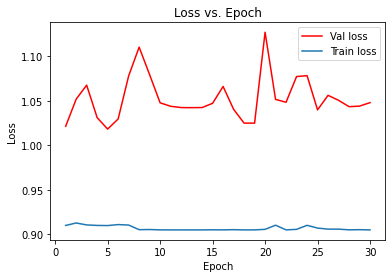

In [77]:
plot_loss(history)

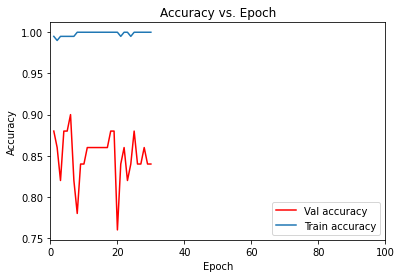

In [78]:
plot_accuracy(history)

### Setup 2 with Adam as optimizer and last convolution block trainable with and without additional dense layer.
#### Results as shown below:
                Setup                              Training Accuracy      Validation Accuracy
                w/out additional dense                   99.5%                   86.4%
                w/ additional 128 dense                  99.5%                   86.8%
                w/ additional 256 dense                  100%                    84.4%
*The accuracy is estimated average of the last 5 epoch

#### Based on above results. Trainable last convolution block with additional 128 dense layer at the output provide a better results. 

### Setup 3, we train the whole VGG16 with and witout additional 128 dense layer at the output.

##### without additional 128 dense layer

In [79]:
base_model_vgg16.trainable = True

In [80]:
model_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [81]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model_vgg16.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=30)

Epoch 1/30
8/8 [==============================] - 121s 15s/step - loss: 0.9264 - categorical_accuracy: 0.9950 - val_loss: 1.0401 - val_categorical_accuracy: 0.8600
Epoch 2/30
8/8 [==============================] - 117s 15s/step - loss: 0.9143 - categorical_accuracy: 0.9950 - val_loss: 1.0478 - val_categorical_accuracy: 0.8600
Epoch 3/30
8/8 [==============================] - 120s 15s/step - loss: 0.9134 - categorical_accuracy: 0.9900 - val_loss: 1.0256 - val_categorical_accuracy: 0.9000
Epoch 4/30
8/8 [==============================] - 124s 16s/step - loss: 0.9077 - categorical_accuracy: 1.0000 - val_loss: 1.0424 - val_categorical_accuracy: 0.8800
Epoch 5/30
8/8 [==============================] - 123s 15s/step - loss: 0.9110 - categorical_accuracy: 1.0000 - val_loss: 1.0218 - val_categorical_accuracy: 0.8800
Epoch 6/30
8/8 [==============================] - 122s 15s/step - loss: 0.9106 - categorical_accuracy: 1.0000 - val_loss: 1.0660 - val_categorical_accuracy: 0.8400
Epoch 7/30
8/8 [

In [83]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  100.0 %
val accuracy:  90.0 %


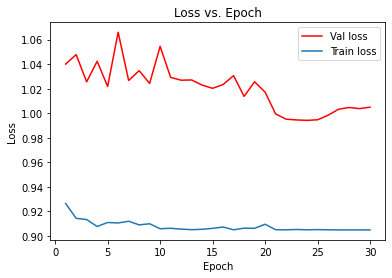

In [85]:
plot_loss(history)

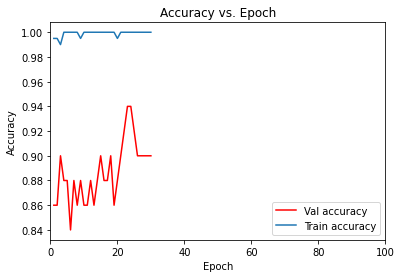

In [86]:
plot_accuracy(history)

##### with additional 128 dense layer

In [87]:
model_vgg16_128.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [88]:
model_vgg16_128.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 14,780,997
Trainable params: 14,780,997
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model_vgg16_128.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=30)

Epoch 1/30
8/8 [==============================] - 106s 13s/step - loss: 0.9050 - categorical_accuracy: 1.0000 - val_loss: 1.1807 - val_categorical_accuracy: 0.7200
Epoch 2/30
8/8 [==============================] - 104s 13s/step - loss: 0.9099 - categorical_accuracy: 0.9950 - val_loss: 1.0614 - val_categorical_accuracy: 0.8400
Epoch 3/30
8/8 [==============================] - 102s 13s/step - loss: 0.9144 - categorical_accuracy: 0.9900 - val_loss: 1.0827 - val_categorical_accuracy: 0.8200
Epoch 4/30
8/8 [==============================] - 100s 13s/step - loss: 0.9166 - categorical_accuracy: 0.9850 - val_loss: 1.0741 - val_categorical_accuracy: 0.8400
Epoch 5/30
8/8 [==============================] - 101s 13s/step - loss: 0.9322 - categorical_accuracy: 0.9750 - val_loss: 0.9913 - val_categorical_accuracy: 0.9200
Epoch 6/30
8/8 [==============================] - 101s 13s/step - loss: 0.9120 - categorical_accuracy: 0.9900 - val_loss: 1.1165 - val_categorical_accuracy: 0.7800
Epoch 7/30
8/8 [

In [90]:
acc=0
v_acc = 0
for a in range(-5, 0, 1):
    acc = history.history['categorical_accuracy'][a] + acc
    v_acc = history.history['val_categorical_accuracy'][a] + v_acc
print('accuracy: ', round(acc/5, 4)*100,'%')
print('val accuracy: ', round(v_acc/5, 4)*100,'%')

accuracy:  100.0 %
val accuracy:  92.0 %


In [91]:
model_vgg16_128.save('vgg16_full_128_out.h5')

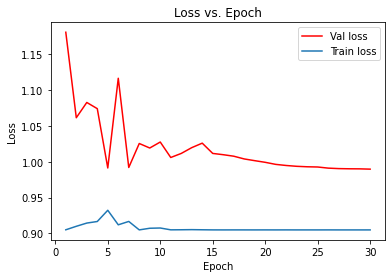

In [92]:
plot_loss(history)

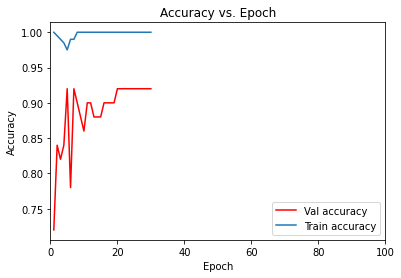

In [93]:
plot_accuracy(history)

## Setup 3 with fully trained VGG16
#### Results as shown below:
                                     Training Accuracy      Validation Accuracy
     w/out additional dense layer          100%                    90.0%
     with additional dense layer 128       100%                    92.0%
     
*The accuracy is estimated average of the last 5 epoch

### Summary of results:
1. Choosing an optimizer
                              Training Accuracy      Validation Accuracy
                    RMSprop        83.5%                   75.2%
                    SGD            86.1%                   75.2%
                    ADAM           91.9%                   84.8%

2. Additional Dense layer at the output stage with different number of nodes.
                no. of nodes  Training Accuracy      Validation Accuracy
                512                 99.3%                   84.0%
                256                 99.1%                   85.2%
                128                 98.7%                   84.0%
                64                  98.1%                   80.8%            
   Conclusion: 128 and 256 nodes have almost the same performance.

3. Trainable last convolution block with and without additional dense layer.
                Setup                              Training Accuracy      Validation Accuracy
                w/out additional dense                   99.5%                   86.4%
                w/ additional 128 dense                  99.5%                   86.8%
                w/ additional 256 dense                  100%                    84.4%
   Conclusion: w/ additional 128 dense layer at the output seems to perform better.

4. The whole VGG16 with and without additional dense layer trainable.
                                          Training Accuracy      Validation Accuracy
          w/out additional dense layer          100%                    90.0%
          with additional dense layer 128       100%                    92.0%                                          
   Conclusion: w/additional 128 dense layer at the output perform a bit better.

### Conclusion:

Using VGG16 transfer learning and fine tuning the model provide us a good quality model that can identify the pokemon.
The model to choose based on the results are:
        1. Trainable last convolution block of VGG16 with additional 128 dense layer at the output.
        2. Trainable whole VGG16 convolution block with additional 128 dense layer at the output.

With these two model above, we can classify the pokemon 90% of the time.
To increase accuracy further, we may need more data/picture of pokemon for training.

Other convolution network like VGG19, Resnet, Mobilenet, etc, can also be use to do transfer learning. 


Note:
1. Provide additional python file to be use for testing by loading the model save on this file.
2. Two model were save. 
        First one is vgg16_full_128_out.h5. This is the full training of VGG16 model with additional dense layer 128 nodes.
        Second one is vgg16_last_128_out.h5. This is the training of the last block of convolution layer with additional 
        dense layer 128 nodes. 
3. No callback, early stop or patient were used. The reason was to see where the model will overfit.
4. All this iteration run was done through DGX server provided by RP. Without those server, it will take so much time for the CPU to provide all the iteration.

## --------------------------------------------------------------------------------------------------------------------------------------